# Geomagnetic Model Residuals through VirES

> Authors: Ashley Smith
>
> Abstract: An exploration of geomagnetic data-model residuals evaluated through VirES (along Swarm orbits).

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

2020-03-12T14:47:27+00:00

CPython 3.7.6
IPython 7.11.1

viresclient 0.6.0
pandas 0.25.3
xarray 0.15.0
matplotlib 3.1.2


In [2]:
from viresclient import SwarmRequest
import matplotlib.pyplot as plt

## One day of residuals (data minus core field model)

In [3]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=["CHAOS-Core"],
    residuals=True,
    auxiliaries=["MLT", "QDLat", "SunZenithAngle"])
data = request.get_between("2019-01-01", "2019-01-02")
ds = data.as_xarray()
ds

[1/1] Processing:  100%|███████████████████████████████████████████████████|  [ Elapsed: 00:04, Remaining: 00:00 ]
      Downloading: 100%|█████████████████████████████████████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (7.004MB)


<xarray.Dataset>
Dimensions:               (NEC: 3, Timestamp: 86400)
Coordinates:
  * Timestamp             (Timestamp) datetime64[ns] 2019-01-01 ... 2019-01-01T23:59:59
  * NEC                   (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft            (Timestamp) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    B_NEC_res_CHAOS-Core  (Timestamp, NEC) float64 -13.26 -18.98 ... 4.701 7.679
    Longitude             (Timestamp) float64 -136.0 -136.0 ... 40.88 40.88
    Latitude              (Timestamp) float64 -17.03 -16.97 -16.9 ... 44.0 43.93
    SunZenithAngle        (Timestamp) float64 40.87 40.89 40.91 ... 141.1 141.2
    QDLat                 (Timestamp) float64 -13.94 -13.88 ... 39.74 39.67
    MLT                   (Timestamp) float64 14.82 14.82 14.82 ... 2.445 2.445
    Radius                (Timestamp) float64 6.819e+06 6.819e+06 ... 6.809e+06
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20190101T000000_20190101T235959_050...
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"]
    RangeFilters:    []

xarray provides some convenient direct plotting tools through integration with matplotlib:

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


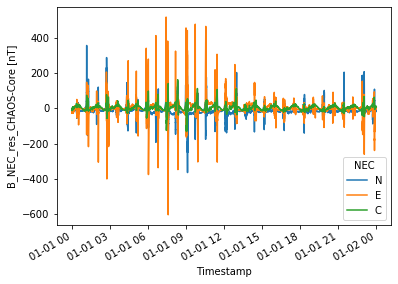

In [4]:
ds["B_NEC_res_CHAOS-Core"].plot.line(x="Timestamp");

This allows some very compact plotting commands to create complex figures, if you know how! This kind of plotting takes a while to learn and experiment with to get right, but results in short and manageable code.

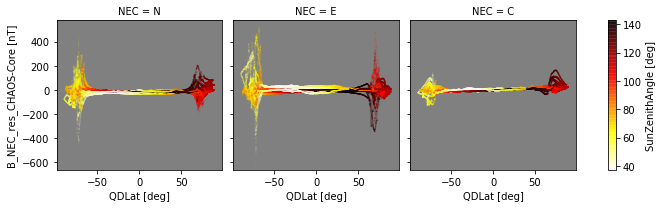

In [5]:
facetgrid = ds.plot.scatter(x="QDLat", y="B_NEC_res_CHAOS-Core", col="NEC",
                s=0.01, hue="SunZenithAngle", cmap="hot_r", alpha=0.6)
for ax in facetgrid.axes.flat:
    ax.set_facecolor("grey")

(showing that we are in daylight more in the Southern hemisphere, while in darkness in the Northern, because the data is from January - Northern winter)

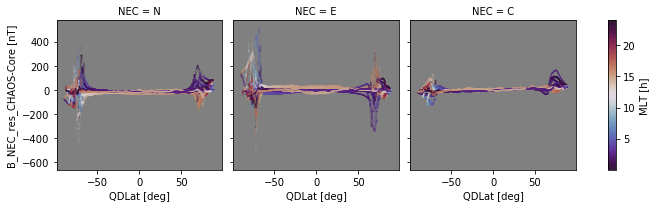

In [6]:
facetgrid = ds.plot.scatter(x="QDLat", y="B_NEC_res_CHAOS-Core", col="NEC",
                s=0.01, hue="MLT", cmap="twilight_shifted", alpha=0.6)
for ax in facetgrid.axes.flat:
    ax.set_facecolor("grey")

(showing the rapid movement through local time sectors (MLT) when the satellite passes through polar regions)

The above figures show large residuals in the polar regions due to currents in the auroral oval. These cause greater disturbance in the Northward (N) and Eastward (E) components of the magnetic field because of the geometry of the field-aligned currents (FACs) which cause the magnetic disturbance.

## Access 1 year of data and models at 1-minute sampling

Fetch the `B_NEC` vector from Swarm Alpha and all parts of the CHAOS model (core, crust, magnetosphere) evaluated at the same points. We also access MLT, QDLat, and SunZenithAngle which are also evaluated on-the-fly.

We fetch the model values themselves as well as the measurements (instead of just the residuals as above) so that we can manipulate all the different components locally.

We apply filters to remove bad data (according to `Flags_F`) and only select geomagnetically quiet data (according to `Kp`).

Warning: Takes several minutes to process

In [7]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=["CHAOS-Core", "CHAOS-Static", "CHAOS-MMA-Primary", "CHAOS-MMA-Secondary"],
    auxiliaries=["MLT", "QDLat", "SunZenithAngle", "OrbitNumber"],
    sampling_step="PT60S")
request.set_range_filter("Flags_F", 0, 1)
request.set_range_filter("Kp", 0, 3)
# request.set_range_filter("SunZenithAngle", 100, 180)
data = request.get_between("2019-01-01", "2020-01-01")
ds = data.as_xarray()
ds

[1/1] Processing:  100%|███████████████████████████████████████████████████|  [ Elapsed: 06:03, Remaining: 00:00 ]
      Downloading: 100%|█████████████████████████████████████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (79.49MB)


<xarray.Dataset>
Dimensions:                    (NEC: 3, Timestamp: 438249)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01 ... 2019-12-31T23:59:00
  * NEC                        (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC_CHAOS-Static         (Timestamp, NEC) float64 -0.1243 1.575 ... 1.596
    Longitude                  (Timestamp) float64 -136.0 -136.1 ... 99.22 100.7
    Latitude                   (Timestamp) float64 -17.03 -13.18 ... 69.06 72.89
    SunZenithAngle             (Timestamp) float64 40.87 42.22 ... 108.7 109.2
    OrbitNumber                (Timestamp) int32 28692 28692 ... 34324 34324
    QDLat                      (Timestamp) float64 -13.94 -10.1 ... 64.81 68.42
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 -13.54 1.041 ... 8.836
    Radius                     (Timestamp) float64 6.819e+06 ... 6.803e+06
    B_NEC                      (Timestamp, NEC) float64 2.368e+04 ... 4.9e+04
    MLT                        (Timestamp) float64 14.82 14.78 ... 6.365 6.455
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 -0.2893 0.9758 ... 1.07
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 2.369e+04 ... 4.899e+04
Attributes:
    Sources:         ['CHAOS-7_static.shc', 'SW_OPER_AUXAORBCNT_20131122T0000...
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    RangeFilters:    ['Flags_F:0,1', 'Kp:0,3']

We can construct `xarray.DataArray`'s based on `ds`:

In [8]:
ds["B_NEC"]

<xarray.DataArray 'B_NEC' (Timestamp: 438249, NEC: 3)>
array([[ 23675.8346,   5295.5528, -12248.486 ],
       [ 24198.5958,   4977.4074,  -8959.4588],
       [ 24573.9348,   4698.8694,  -5597.7083],
       ...,
       [  7777.6078,    199.8677,  49058.0031],
       [  6013.3288,    276.343 ,  49152.1673],
       [  4458.6813,    339.1338,  48999.3154]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2019-01-01 ... 2019-12-31T23:59:00
  * NEC        (NEC) <U1 'N' 'E' 'C'
Attributes:
    units:        nT
    description:  Magnetic field vector, NEC frame

In [9]:
ds["B_NEC"] - ds["B_NEC_CHAOS-Core"]

<xarray.DataArray (Timestamp: 438249, NEC: 3)>
array([[-13.26435878, -18.97622904,  -1.10562364],
       [-10.97259003, -26.93279989,  -2.36701252],
       [-10.33103042, -24.63169489, -11.00896392],
       ...,
       [ -1.93303233,   2.55359157,   5.80898772],
       [  1.73480118,   5.71495966,   6.36652552],
       [ -0.3656429 ,   1.07605691,   6.38765681]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2019-01-01 ... 2019-12-31T23:59:00
  * NEC        (NEC) <U1 'N' 'E' 'C'

... and we can plot these directly:

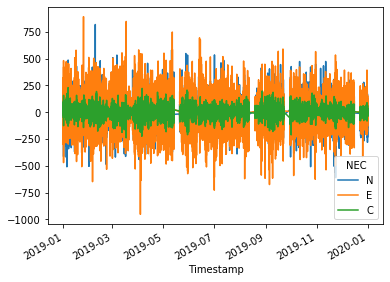

In [10]:
(ds["B_NEC"] - ds["B_NEC_CHAOS-Core"]).plot.line(x="Timestamp");

We can slice out a particular time window:

In [11]:
# Selects two days
ds.sel({"Timestamp": slice("2019-01-01", "2019-01-02")})

<xarray.Dataset>
Dimensions:                    (NEC: 3, Timestamp: 2830)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01 ... 2019-01-02T23:59:00
  * NEC                        (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC_CHAOS-Static         (Timestamp, NEC) float64 -0.1243 1.575 ... -1.676
    Longitude                  (Timestamp) float64 -136.0 -136.1 ... -147.5
    Latitude                   (Timestamp) float64 -17.03 -13.18 ... -74.84
    SunZenithAngle             (Timestamp) float64 40.87 42.22 ... 57.18 54.47
    OrbitNumber                (Timestamp) int32 28692 28692 ... 28723 28723
    QDLat                      (Timestamp) float64 -13.94 -10.1 ... -69.12
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 -13.54 1.041 ... -12.36
    Radius                     (Timestamp) float64 6.819e+06 ... 6.823e+06
    B_NEC                      (Timestamp, NEC) float64 2.368e+04 ... -4.543e+04
    MLT                        (Timestamp) float64 14.82 14.78 ... 17.36 16.86
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 -0.2893 ... -0.03726
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 2.369e+04 ... -4.541e+04
Attributes:
    Sources:         ['CHAOS-7_static.shc', 'SW_OPER_AUXAORBCNT_20131122T0000...
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    RangeFilters:    ['Flags_F:0,1', 'Kp:0,3']

... and subselect according to parts of the data:

In [12]:
ds.where(ds["SunZenithAngle"] > 100, drop=True)

<xarray.Dataset>
Dimensions:                    (NEC: 3, Timestamp: 170180)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01T00:23:00 ... 2019-12-31T23:59:00
  * NEC                        (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC_CHAOS-Static         (Timestamp, NEC) float64 -3.15 1.445 ... 1.596
    Longitude                  (Timestamp) float64 -133.0 -131.0 ... 99.22 100.7
    Latitude                   (Timestamp) float64 71.57 75.39 ... 69.06 72.89
    SunZenithAngle             (Timestamp) float64 101.1 104.1 ... 108.7 109.2
    OrbitNumber                (Timestamp) float64 2.869e+04 ... 3.432e+04
    QDLat                      (Timestamp) float64 74.33 78.17 ... 64.81 68.42
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 -0.5274 ... 8.836
    Radius                     (Timestamp) float64 6.805e+06 ... 6.803e+06
    B_NEC                      (Timestamp, NEC) float64 5.335e+03 ... 4.9e+04
    MLT                        (Timestamp) float64 13.67 13.42 ... 6.365 6.455
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 1.182 0.2297 ... 1.07
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 5.359e+03 ... 4.899e+04
Attributes:
    Sources:         ['CHAOS-7_static.shc', 'SW_OPER_AUXAORBCNT_20131122T0000...
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    RangeFilters:    ['Flags_F:0,1', 'Kp:0,3']

We can use the above to construct a plot based on part of the data

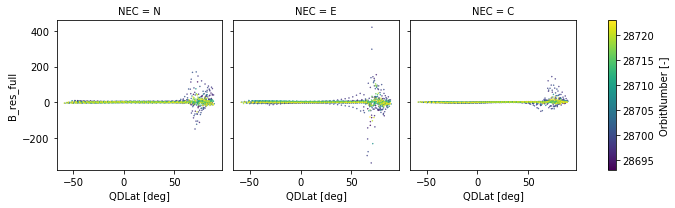

In [13]:
# Select one day
_ds = ds.sel({"Timestamp": slice("2019-01-01", "2019-01-02")})
# Select nightside data from it
_ds_dark = _ds.where(_ds["SunZenithAngle"] > 100, drop=True)
# Append a custom residual of B-MCO-MLI-MMA
_ds_dark["B_res_full"] = _ds_dark["B_NEC"] - _ds_dark["B_NEC_CHAOS-Core"] \
                                           - _ds_dark["B_NEC_CHAOS-Static"] \
                                           - _ds_dark["B_NEC_CHAOS-MMA-Primary"] \
                                           - _ds_dark["B_NEC_CHAOS-MMA-Secondary"]
_ds_dark.plot.scatter(x="QDLat", y="B_res_full", hue="OrbitNumber", col="NEC",
                      cmap="viridis", s=0.2);

## Plotting residuals to different model combinations from one month of data

First we adjust the `Dataset` so that it contains the custom residuals themselves. We store them as both regular `data variables` and as a higher dimensional `"B_residuals"` which includes all of them. This is inefficient but is convenient for the plotting tools used below.

In [14]:
def assign_residuals(ds):
    # Work on a copy of the Dataset so we don't disturb the original
    ds = ds.copy()
    # Assign custom residual variables
    ds["B-MCO"] = ds["B_NEC"] - ds["B_NEC_CHAOS-Core"]
    ds["B-MCO-MLI"] = ds["B-MCO"] - ds["B_NEC_CHAOS-Static"]
    ds["B-MCO-MLI-MMA"] = ds["B-MCO-MLI"] - ds["B_NEC_CHAOS-MMA-Primary"]\
                                          - ds["B_NEC_CHAOS-MMA-Secondary"]
    # Create a new DataArray to contain all these residual combinations
    da = ds["B_NEC"].copy()
    da.name = "B_residuals"
    # Expand to 3 dimensions for each residual combination to use
    da = da.expand_dims({"residuals": 3})
    da.coords["residuals"] = ["B-MCO", "B-MCO-MLI", "B-MCO-MLI-MMA"]
    # Assign the residual data to the DataArray
    da = da.copy()
    da.loc[{"residuals": "B-MCO"}] = ds["B-MCO"]
    da.loc[{"residuals": "B-MCO-MLI"}] = ds["B-MCO-MLI"]
    da.loc[{"residuals": "B-MCO-MLI-MMA"}] = ds["B-MCO-MLI-MMA"]
    # Assign the new DataArray to the original Dataset
    ds["B_residuals"] = da
    return ds

ds = assign_residuals(ds)
ds

<xarray.Dataset>
Dimensions:                    (NEC: 3, Timestamp: 438249, residuals: 3)
Coordinates:
  * Timestamp                  (Timestamp) datetime64[ns] 2019-01-01 ... 2019-12-31T23:59:00
  * NEC                        (NEC) <U1 'N' 'E' 'C'
  * residuals                  (residuals) <U13 'B-MCO' ... 'B-MCO-MLI-MMA'
Data variables:
    Spacecraft                 (Timestamp) object 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC_CHAOS-Static         (Timestamp, NEC) float64 -0.1243 1.575 ... 1.596
    Longitude                  (Timestamp) float64 -136.0 -136.1 ... 99.22 100.7
    Latitude                   (Timestamp) float64 -17.03 -13.18 ... 69.06 72.89
    SunZenithAngle             (Timestamp) float64 40.87 42.22 ... 108.7 109.2
    OrbitNumber                (Timestamp) int32 28692 28692 ... 34324 34324
    QDLat                      (Timestamp) float64 -13.94 -10.1 ... 64.81 68.42
    B_NEC_CHAOS-MMA-Primary    (Timestamp, NEC) float64 -13.54 1.041 ... 8.836
    Radius                     (Timestamp) float64 6.819e+06 ... 6.803e+06
    B_NEC                      (Timestamp, NEC) float64 2.368e+04 ... 4.9e+04
    MLT                        (Timestamp) float64 14.82 14.78 ... 6.365 6.455
    B_NEC_CHAOS-MMA-Secondary  (Timestamp, NEC) float64 -0.2893 0.9758 ... 1.07
    B_NEC_CHAOS-Core           (Timestamp, NEC) float64 2.369e+04 ... 4.899e+04
    B-MCO                      (Timestamp, NEC) float64 -13.26 -18.98 ... 6.388
    B-MCO-MLI                  (Timestamp, NEC) float64 -13.14 -20.55 ... 4.792
    B-MCO-MLI-MMA              (Timestamp, NEC) float64 0.6921 -22.57 ... -5.115
    B_residuals                (residuals, Timestamp, NEC) float64 -13.26 ... -5.115
Attributes:
    Sources:         ['CHAOS-7_static.shc', 'SW_OPER_AUXAORBCNT_20131122T0000...
    MagneticModels:  ["CHAOS-Core = 'CHAOS-Core'(max_degree=20,min_degree=1)"...
    RangeFilters:    ['Flags_F:0,1', 'Kp:0,3']

Here we create scatter plots to show the data in different views. We select only the first month - this reduces the crowding on the figures but shows that we should seek different methods to produce summary views of the data for longer time periods. 

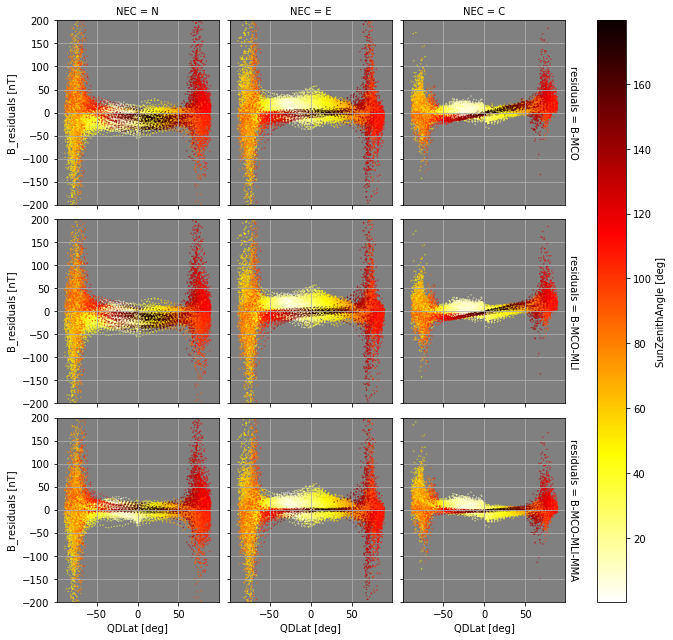

In [15]:
facetgrid = (
    ds.sel({"Timestamp": slice("2019-01-01", "2019-02-01")})
      .plot.scatter(x="QDLat", y="B_residuals", col="NEC", row="residuals",
                    sharex="all", sharey="row", s=0.1,
                    hue="SunZenithAngle", cmap="hot_r"))
for ax in facetgrid.axes.flat:
    ax.set_facecolor("grey")
    ax.grid()
    ax.set_ylim((-200, 200))

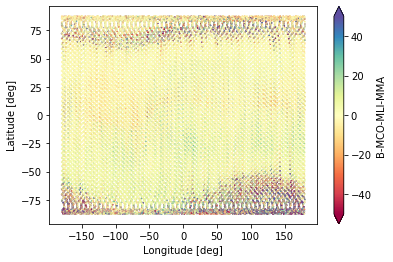

In [16]:
(
    ds
    .sel({"Timestamp": slice("2019-01-01", "2019-02-01")})
    .plot.scatter(x="Longitude", y="Latitude", hue="B-MCO-MLI-MMA",
                  s=0.1, cmap="Spectral", vmin=-50, vmax=50)
);

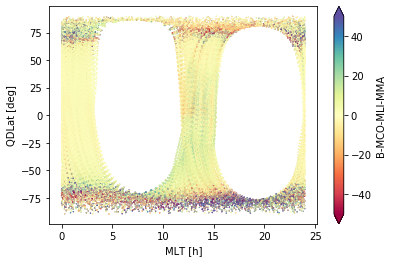

In [17]:
(
    ds
    .sel({"Timestamp": slice("2019-01-01", "2019-02-01")})
    .plot.scatter(x="MLT", y="QDLat", hue="B-MCO-MLI-MMA",
                  s=0.1, cmap="Spectral", vmin=-50, vmax=50)
);

## Statistical summaries of data over the full year

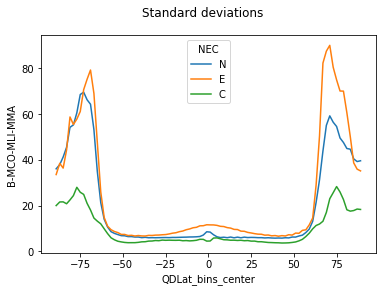

In [18]:
(
    ds
       .groupby_bins("QDLat", 90)
       .std()["B-MCO-MLI-MMA"]
       .plot.line(x="QDLat_bins")
)
plt.suptitle("Standard deviations");

to be continued